<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Goolge_CoLab_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow==2.0.0-beta1

In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Concatenate, GlobalMaxPooling2D, MaxPooling1D, GaussianNoise, BatchNormalization, MaxPooling2D, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D, Embedding, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import mnist

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from scipy import stats
import math
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
import re
import os

### Loading the Data

In [0]:
mnist = mnist

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [43]:
np.max (X_train[0])

255

255

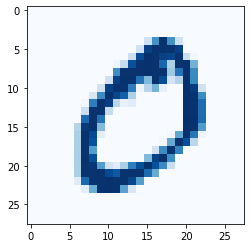

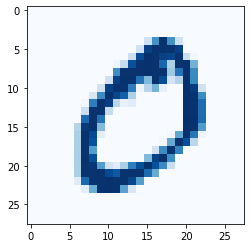

In [44]:
plt.imshow (X_train[1], cmap='Blues')

In [0]:
X_train = X_train / 255.0 * 2 - 1
X_test = X_test / 255.0 * 2 - 1

In [0]:
N, H, W = X_train.shape
D = H * W

In [0]:
X_train = X_train.reshape (-1, D)

In [0]:
X_test = X_test.reshape (-1, D)

In [49]:
X_train.shape

(60000, 784)

(60000, 784)

In [0]:
latent = 100

### *Generator*

In [0]:
def generator_nn (latent):
  i = Input (shape=(latent,))
  x = Dense (256, activation=LeakyReLU(alpha=0.2))  (i)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (512, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (1024, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (D, activation='tanh') (x) # values are -1 to 1, centered at 0

  model = Model (i, x)
  return model

### *Discrimnator*

In [0]:
def discriminator_nn (image):
  i = Input (shape=(image,))
  x = Dense (512, activation=LeakyReLU(alpha=0.2))  (i)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (256, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (128, activation=LeakyReLU(alpha=0.2))  (x)
  x = BatchNormalization (momentum=0.8) (x)
  x = Dense (1, activation='sigmoid') (x)
  model = Model (i, x)
  return model

### *Compile and Combine* 

In [0]:
discriminator = discriminator_nn (D)
discriminator.compile (
    loss = 'binary_crossentropy',
    optimizer = Adam (0.0002, 0.5),
    metrics=['accuracy']
)

In [0]:
generator = generator_nn (latent)
z = Input (shape=(latent,)) # noise sample
image = generator (z) # pass z into the generator

discriminator.trainable = False # freeze weights

fake_pred = discriminator (image) # pass 'image' into discrimator, labeled 'real', this will be flipped later
                                  # true output is fake, by labeled as real

combined = Model (z, fake_pred)

combined.compile (
    loss = 'binary_crossentropy',
    optimizer = Adam (0.0002, 0.5)
)

### *Training*

In [0]:
batch = 32
epochs = 12000
sample_period = 2000 # show a sample every 'n' periods

In [0]:
ones = np.ones (batch) # creating batch labels ahead of time

In [0]:
zeros = np.zeros (batch)

In [0]:
d_losses = []
g_losses = []

In [0]:
#os.makedirs ('gan_images') # storage

In [0]:
def sample_images (epoch):
  rows, cols = 5, 5
  noise = np.random.randn (rows*cols, latent)
  images = generator.predict (noise) # have the generator make a sample image from the noise

  images = 0.5 * images + 0.5 # rescaling to be between 0 and 1

  fig, axs = plt.subplots (rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(images[idx].reshape(H,W), cmap='Reds')
      axs[i, j].axis('off')
      idx += 1 # this is just graphing 1 by 1
  fig.savefig ('gan_images/%d.png' % epoch)
  plt.close()

In [61]:
indexes = np.random.randint (0, X_train.shape[0], batch)
real = X_train [indexes]
np.sqrt (real.shape[1])

28.0

28.0

In [0]:
noisy = np.random.randn (batch, latent)

In [63]:
generator.predict(noisy).shape, real.shape

((32, 784), (32, 784))

((32, 784), (32, 784))

In [64]:
for epoch in range (epochs):
  # train discriminator
  idx = np.random.randint (0, X_train.shape[0], batch) # select random images from index 0 to size of X_train, in a batch size group
  real_images = X_train [idx]

  noise = np.random.randn (batch, latent)
  fake_images = generator.predict(noise)

  # generator.trainable = False
  # discriminator.trainable = True

  # print (discriminator.trainable)

  d_loss_real, d_acc_real = discriminator.train_on_batch (real_images, ones) # (X, y)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch (fake_images, zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake) # mean of losses and accuracies
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  if epoch % sample_period == 0:
    print ('Trainable (D) : %a ' %discriminator.trainable)

  # train generator
  noise = np.random.randn (batch, latent)
  
  # generator.trainable = True
  # discriminator.trainable = False

  

  g_loss = combined.train_on_batch (noise, ones) # flipped from discriminator

  d_losses.append (d_loss)
  g_losses.append (g_loss)

  if epoch % sample_period == 0:
    print ('Trainable (G) : %a ' %discriminator.trainable)
    print ('Discriminator Loss : %a' %d_loss)
    print ('Generator Loss : %a' %g_loss) 
    print ('Epoch : %a' %epoch )
    print ('***')

  if epoch % 1000 == 0:
    sample_images (epoch=epoch)

Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.9421792030334473
Generator Loss : 0.7916252
Epoch : 0
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.5610976815223694
Generator Loss : 1.2930362
Epoch : 2000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.5572822093963623
Generator Loss : 1.3456163
Epoch : 4000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.5941658020019531
Generator Loss : 1.1617236
Epoch : 6000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.6482244729995728
Generator Loss : 1.2697659
Epoch : 8000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.5760209560394287
Generator Loss : 1.1079345
Epoch : 10000
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.7299424409866333
Generator Loss : 0.6062914
Epoch : 0
***
Trainable (D) : False 
Trainable (G) : False 
Discriminator Loss : 0.5830203294754028
Generator

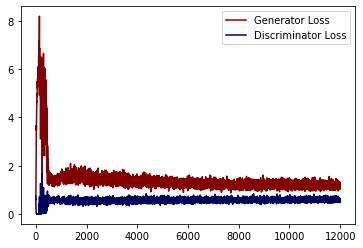

In [69]:
plt.plot (g_losses, label='Generator Loss', color='#840000')
plt.plot (d_losses, label='Discriminator Loss', color='#00035b')
plt.legend ()

### Plotting Results

In [0]:
from skimage.io import imread

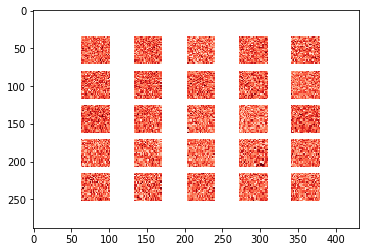

In [71]:
a = imread('gan_images/0.png')
plt.imshow (a)

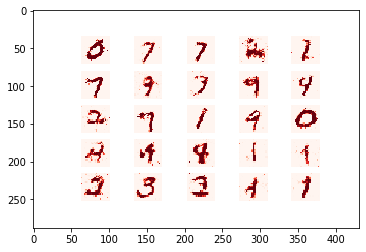

In [72]:
a = imread('gan_images/10000.png')
plt.imshow (a)